<a href="https://colab.research.google.com/github/stefanopieri/machine_learning_module/blob/main/ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip3 install keras
!pip3 install tensorflow
!pip install random
!pip3 install opencv-python
!pip3 install numpy
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install os


ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import RMSprop, Adam
from functools import partial
import cv2
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.applications import efficientnet_v2, efficientnet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions, EfficientNetV2S
import os
import keras



def classical_augmentation(INPUT_FOLDER_ADDRESS, OUTPUT_FOLDER_ADDRESS):
    classical_augm_net = Sequential([RandomFlip("horizontal"),
                                     RandomRotation(factor=(-0.05, 0.05)),
                                     RandomTranslation(height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15),
                                                       fill_mode='constant'), ])

    # take ls of files in the input folder
    ls = os.listdir(INPUT_FOLDER_ADDRESS)
    #print(ls)
    # loop across the ls of files
    for file in ls:
        #print(str(file)[-4:])
        if str(file)[-4:] == '.png':
            print(file[:-4])


            #   import image w cv2
            image = cv2.imread(str(INPUT_FOLDER_ADDRESS+'/'+str(file)))

            for ix in range(0, 10):
                img = classical_augm_net(image, training=True)
                img = img.numpy()
                print(type(img))
                print(img.shape)
                # plt.savefig(img, OUTPUT_FOLDER_ADDRESS + '/' + pic_name[:-4] + '_' + str(ix))
                cv2.imwrite(OUTPUT_FOLDER_ADDRESS + '/' + str(file)[:-4] + '_' + str(ix)+'.png', img)



def calculate_labels_for_classical_augm_data(ADDRESS_OLD_DATAFRAME):
    # take ls of files in the input folder
    data = []
    df = pd.read_csv(ADDRESS_OLD_DATAFRAME, header=0, index_col=0)
    df = df[['ix', 'mask_condition']]
    ls_ix = df['ix'].values.astype('str')

    #print(ls_ix)

    for name in ls_ix:
        for i in range(0,10):
            print([name+'_'+str(i), df[df['ix'].astype('str')==name]['mask_condition'].values[0]])
            data.append([name+'_'+str(i), df[df['ix'].astype('str')==name]['mask_condition'].values[0]])

    #print(data)
    df2 = pd.DataFrame(data, columns=['ix', 'mask_condition'])
    df2['mask_condition'] = df2['mask_condition'].apply(lambda row : 0 if str(row)=='with_mask' else (1 if str(row)=='mask_weared_incorrect' else 2))
    print(df2)
    df2.to_csv(path_or_buf='classical_augm_images/annotations/annotations.csv')

    #ls = os.listdir(INPUT_FOLDER_ADDRESS)


def replace_incorrect_names(x):
    if str(x[-3:]) == 'png':

        return x
    else:
        #print(x[-3:])
        return '0_0_0.png'


def replace_incorrect_names_val(x):
    if str(x[-3:]) == 'png':
        return x
    else:
        pass
        #print(x[-3:])
        #return '0_0_0.png'


def repl_incorrect_names_from_list(ls):
    out_ls=[]
    for x in ls:
        if str(x[-3:]) == 'png':
            out_ls= out_ls.append(str(x))
        else:
            pass
    print(out_ls)
    return out_ls


def weighted_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in np.product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])

    return K.categorical_crossentropy(y_pred, y_true) * final_mask


def generate_weight_matrix():
    w = np.zeros((3, 3))
    w[0, 0] = 25.5/100
    w[0, 1] = 25.5/100
    w[0, 2] = 25.5/100
    w[1, 0] = 2/100
    w[1, 1] = 2/100
    w[1, 2] = 2/100
    w[2, 0] = 6/100
    w[2, 1] = 6/100
    w[2, 2] = 6/100
    return w

def generate_training_batch(batch_size, PATH_IMAGES = 'classical_augm_images/images',
                            PATH_LABELS = 'classical_augm_images/annotations/annotations.csv'
                             ):
    ls = []
    ls_files = os.listdir(PATH_IMAGES)

    sample_images = random.sample(ls_files, batch_size)
    sample_images = list(map(replace_incorrect_names, sample_images))
    print(sample_images)
    # print(sample_images)
    for img_name in sample_images:
        #print(img_name[:-4])
        #print(PATH_IMAGES + '/'+str(img_name)+'.png')
        img=cv2.imread(PATH_IMAGES + '/'+str(img_name))
        ls.append(img)
        #print(ls)

    df = pd.read_csv(PATH_LABELS, header=0, index_col=0)


    sample_images = [element[:-4] for element in sample_images]

    y = df[df.ix.isin(sample_images)]['mask_condition'].to_numpy()

    #print(y)
    print(np.array(ls, dtype='float64').shape)
    print(y.shape)
    print(y)
    X = np.array(ls, dtype='float64').reshape((batch_size, 80, 80, 3))
    return X, y

    #print(sample_images)
        #ls.append

def get_img_names_list(PATH_IMAGES):

    ls_files = os.listdir(PATH_IMAGES)
    for element in ls_files:
        if element.startswith('.'):
            ls_files.remove(element)
        else:
            pass
    return ls_files


def generate_training_data(batch_size, PATH_IMAGES = 'classical_augm_images/images',
                            PATH_LABELS = 'classical_augm_images/annotations/annotations.csv'
                             ):
    ls = []



    #ls_files = os.listdir(PATH_IMAGES)

    ls_files = get_img_names_list(PATH_IMAGES)


    sample_images = random.sample(ls_files, batch_size)
    print(sample_images)
    #if '.DS_store' in sample_images:
    #    sample_images=sample_images.remove('.DS_store')

    sample_images = list(map(replace_incorrect_names, sample_images))
#    sample_images = repl_incorrect_names_from_list(sample_images)
    # print(sample_images)
    # print(sample_images)
    for img_name in sample_images:
        #print(img_name[:-4])
        #print(PATH_IMAGES + '/'+str(img_name)+'.png')
        img=cv2.imread(PATH_IMAGES + '/'+str(img_name))
        ls.append(img)
        #print(ls)

    df = pd.read_csv(PATH_LABELS, header=0, index_col=0)


    sample_images = [element[:-4] for element in sample_images]

    y = df[df.ix.isin(sample_images)]['mask_condition'].to_numpy()

    #print(y)
    #print(len(sample_images))
    #annot=pd.read_csv('/Volumes/seagate_expans/classical_augm_images/annotations/annotations.csv', header=0)['ix'].to_numpy().tolist()
    #print(sample_images)
    #quit()
    #print('printing annot:')
    #print(annot)
    #flat_list = [str(item) for sublist in annot for item in sublist]

    #print(set(sample_images).difference(set(flat_list)))
    #quit()
    #print(df[~df.ix.isin(sample_images)].to_numpy())
    #quit()
    #print(np.array(ls, dtype='float64').shape)
    print(y.shape)
    print(y)
    X = np.array(ls, dtype='float64').reshape((batch_size, 80, 80, 3))
    return X, y

    #print(sample_images)
        #ls.append



def freq_class(int_class, PATH_TO_ANNOTATIONS = 'classical_augm_images/annotations/annotations.csv'):
    df = pd.read_csv(PATH_TO_ANNOTATIONS, header=0, index_col=0)
    class_count = df[df['mask_condition'].astype('int32')==int_class].count().values[0]
    #print(class_count)
    tot_count = len(df.index)
    #print(tot_count)
    return class_count/tot_count



def train_evaluate_network_strategy_1(training_set_size = 1000, n_epochs=350,
                                      n_batch_update = 128,
                                      batch_size=32,
                                      val_ratio=0.1,
                                      save_freq_param=50, 
                                      class_weights={0:1/freq_class(0),1:1/freq_class(1), 2:1/freq_class(2)}):
    # model instantiation
    base_model = EfficientNetV2S(include_top=True,
                            weights=None,
                            input_tensor=None,
                            input_shape=(80, 80, 3),
                            pooling=None,
                            classes=3,
                            classifier_activation="softmax",
                            include_preprocessing=True)

    #model = Sequential()
    #for layer in base_model.layers[:-1]:
    #    model.add(layer)
    #model.add(Dense(1, activation='softmax'))


    #model2 = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    #dense = Dense(1000, activation='relu')(model2.output)
    #output = Dense(3, activation='sigmoid')(dense)
    #tot_model = Model(inputs=base_model.input, outputs=output)
    tot_model=base_model
    tot_model.summary()

    # define optimizer &  scheduler
    lr_schedule = ExponentialDecay(initial_learning_rate=0.256,
    decay_steps=3,
    decay_rate=0.965)
    opt = Adam(learning_rate=lr_schedule)
    opt2 = RMSprop(learning_rate=lr_schedule, momentum=0.9)
    # define a loss function
    loss_function = keras.losses.CategoricalCrossentropy(from_logits=False)

    # callback for early stoppage
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


    # model compilation
    tot_model.compile(loss=loss_function, optimizer=opt, metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    # load training validation data
    X, y = generate_training_data(training_set_size)
    #print(X.shape)
    #print(X)
    #quit()
    X = preprocess_input(X)

    print(X.shape)
    print(y.shape)
    y_train_one_hot = np.array(pd.Series(y).apply(
        lambda x: [1, 0, 0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1])).values.tolist()).reshape(
        (training_set_size, 3))

    training_metrics = tot_model.fit(x = X, y = y_train_one_hot,
                  epochs=n_epochs,
                  batch_size=batch_size,
                  steps_per_epoch=n_batch_update,
                  validation_split=val_ratio,
                  class_weight=class_weights,
                  #class_weight=None,
                  shuffle=True, # shuffles after selecting validation data
                  callbacks=[callback],
                  workers=-1,
                  use_multiprocessing=True,
                  verbose=2)

    # loading test data
    X_test, y_test = generate_training_data(training_set_size)
    X_test = preprocess_input(X_test)

    y_test_one_hot = np.array(pd.Series(y_test).apply(
        lambda x: [1, 0, 0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1])).values.tolist()).reshape(
        (training_set_size, 3))

    test_metrics = tot_model.evaluate(x=X_test, y=y_test_one_hot, steps=3)
    return training_metrics, test_metrics, tot_model


        # tot model saved weights
        #if n % save_freq_param == 0:
        #    tot_model.save_weights('models/effectivenet_epoch_'+str(n))

# return ls of f1 scores
def calculate_element_wise_f1_score(ls_prec, ls_recall):
    prec=np.array(ls_prec)
    rec=np.array(ls_recall)
    return 2*prec*rec/(prec+rec)



if __name__ =='__main__':

    ANNOTATIONS_ADDRESS = '/Volumes/seagate_expans/input_data/annotations'
    INPUT_IMAGES_ADDRESS = '/Volumes/seagate_expans/input_data/images'
    OUTPUT_IMAGES_ADDRESS = '/Volumes/seagate_expans/input_data/out_images'

    INPUT_FOLDER_ADDRESS = '/Volumes/seagate_expans/processed_images'
    OUTPUT_FOLDER_ADDRESS =  '/Volumes/seagate_expans/classical_augm_images/images'

    # classical_augmentation(INPUT_FOLDER_ADDRESS, OUTPUT_FOLDER_ADDRESS)
    # calculate_labels_for_classical_augm_data('/Volumes/seagate_expans/processed_images/annotations.csv' )


    # VALIDATION DATA
    VALIDATION_DATA_PATH = '/Volumes/seagate_expans/val_classical_augm_images/images'

    # TEST DATA
    TEST_DATA_PATH = '/Volumes/seagate_expans/test_images'


    DATA_FIRST_PART_TRAINING = 'address'
    DATA_SECOND_PART_TRAINING = 'address'


    freq0=freq_class(0)
    freq1 = freq_class(1)
    freq2 = freq_class(2)

    BATCH_SIZE=32
    #X, y = generate_training_batch(batch_size=BATCH_SIZE)
    #X = preprocess_input(X)

    training_metrics, test_metrics, tot_model = train_evaluate_network_strategy_1()
    print(training_metrics.history)
    print('Test metrics: {}'.format(test_metrics))

    #[a * b for a, b in zip(lista, listb)]


    f1_training = calculate_element_wise_f1_score(training_metrics.history['precision'],
                                                  training_metrics.history['recall'])
    f1_val = calculate_element_wise_f1_score(training_metrics.history['val_precision'],
                                             training_metrics.history['val_recall'])

    # print(f1_training)
    # print(f1_val)

    fig, axs = plt.subplots(4)
    fig.suptitle('Train vs validation metrics')

    axs[0].plot(training_metrics.history['loss'], color='k')
    axs[0].plot(training_metrics.history['val_loss'], color='r')
    axs[0].set(ylabel='Loss')


    axs[1].plot(training_metrics.history['precision'], color='k')
    axs[1].plot(training_metrics.history['val_precision'], color='r')
    axs[1].set(ylabel='Precision')


    axs[2].plot(training_metrics.history['recall'], color='k')
    axs[2].plot(training_metrics.history['val_recall'], color='r')
    axs[2].set(ylabel='Recall')

    '''
    axs[3].plot(training_metrics.history['auc'], color='k')
    axs[3].plot(training_metrics.history['val_auc'], color='r')
    axs[3].set(ylabel='AUC')
    axs[3].set(ylabel='F1 score', xlabel='Epoch')

    '''

    plt.show()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 80, 80, 3)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 40, 40, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 40, 40, 24)   96          ['stem_conv[0][0]']              
                                                                                   

In [ ]:
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.metrics import confusion_matrix
import cv2
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
import matplotlib.pyplot as plt
import pandas as pd

import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.applications import efficientnet_v2, efficientnet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions, EfficientNetV2S
# from tensorflow.math import confusion_matrix
import os
import keras


def classical_augmentation(INPUT_FOLDER_ADDRESS, OUTPUT_FOLDER_ADDRESS):
    classical_augm_net = Sequential([RandomFlip("horizontal"),
                                     RandomRotation(factor=(-0.05, 0.05)),
                                     RandomTranslation(height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15),
                                                       fill_mode='constant'), ])

    # take ls of files in the input folder
    ls = os.listdir(INPUT_FOLDER_ADDRESS)
    #print(ls)
    # loop across the ls of files
    for file in ls:
        #print(str(file)[-4:])
        if str(file)[-4:] == '.png':
            print(file[:-4])


            #   import image w cv2
            image = cv2.imread(str(INPUT_FOLDER_ADDRESS+'/'+str(file)))

            for ix in range(0, 10):
                img = classical_augm_net(image, training=True)
                img = img.numpy()
                print(type(img))
                print(img.shape)
                # plt.savefig(img, OUTPUT_FOLDER_ADDRESS + '/' + pic_name[:-4] + '_' + str(ix))
                cv2.imwrite(OUTPUT_FOLDER_ADDRESS + '/' + str(file)[:-4] + '_' + str(ix)+'.png', img)



def calculate_labels_for_classical_augm_data(ADDRESS_OLD_DATAFRAME, ADDRESS_NEW_DATAFRAME):
    # take ls of files in the input folder
    data = []
    df = pd.read_csv(ADDRESS_OLD_DATAFRAME, header=0, index_col=0)
    df = df[['ix', 'mask_condition']]
    ls_ix = df['ix'].values.astype('str')

    #print(ls_ix)

    for name in ls_ix:
        for i in range(0,10):
            print([name+'_'+str(i), df[df['ix'].astype('str')==name]['mask_condition'].values[0]])
            data.append([name+'_'+str(i), df[df['ix'].astype('str')==name]['mask_condition'].values[0]])

    #print(data)
    df2 = pd.DataFrame(data, columns=['ix', 'mask_condition'])
    df2['mask_condition'] = df2['mask_condition'].apply(lambda row : 0 if str(row)=='with_mask' else (1 if str(row)=='mask_weared_incorrect' else 2))
    print(df2)
    df2.to_csv(path_or_buf=ADDRESS_NEW_DATAFRAME)

    #ls = os.listdir(INPUT_FOLDER_ADDRESS)


def calculate_labels(ADDRESS_OLD_DATAFRAME, ADDRESS_NEW_DATAFRAME):
    # take ls of files in the input folder
    data = []
    df = pd.read_csv(ADDRESS_OLD_DATAFRAME, header=0, index_col=0)
    df = df[['ix', 'mask_condition']]
    df['mask_condition'] = df['mask_condition'].apply(lambda row : 0 if str(row)=='with_mask' else (1 if str(row)=='mask_weared_incorrect' else 2))
    print(df)
    df.to_csv(path_or_buf=ADDRESS_NEW_DATAFRAME)

    #ls = os.listdir(INPUT_FOLDER_ADDRESS)


def replace_incorrect_names(x):
    if str(x[-3:]) == 'png':

        return x
    else:
        #print(x[-3:])
        return '0_0_0.png'


def replace_incorrect_names_val(x):
    if str(x[-3:]) == 'png':
        return x
    else:
        pass
        #print(x[-3:])
        #return '0_0_0.png'


def repl_incorrect_names_from_list(ls):
    out_ls=[]
    for x in ls:
        if str(x[-3:]) == 'png':
            out_ls= out_ls.append(str(x))
        else:
            pass
    print(out_ls)
    return out_ls


def weighted_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in np.product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])

    return K.categorical_crossentropy(y_pred, y_true) * final_mask


def generate_weight_matrix():
    w = np.zeros((3, 3))
    w[0, 0] = 25.5/100
    w[0, 1] = 25.5/100
    w[0, 2] = 25.5/100
    w[1, 0] = 2/100
    w[1, 1] = 2/100
    w[1, 2] = 2/100
    w[2, 0] = 6/100
    w[2, 1] = 6/100
    w[2, 2] = 6/100
    return w

def generate_training_batch(batch_size, PATH_IMAGES = '/Volumes/seagate_expans/classical_augm_images/images',
                            PATH_LABELS = '/Volumes/seagate_expans/classical_augm_images/annotations/annotations.csv'
                             ):
    ls = []
    ls_files = os.listdir(PATH_IMAGES)

    sample_images = random.sample(ls_files, batch_size)
    sample_images = list(map(replace_incorrect_names, sample_images))
    print(sample_images)
    # print(sample_images)
    for img_name in sample_images:
        #print(img_name[:-4])
        #print(PATH_IMAGES + '/'+str(img_name)+'.png')
        img=cv2.imread(PATH_IMAGES + '/'+str(img_name))
        ls.append(img)
        #print(ls)

    df = pd.read_csv(PATH_LABELS, header=0, index_col=0)


    sample_images = [element[:-4] for element in sample_images]

    y = df[df.ix.isin(sample_images)]['mask_condition'].to_numpy()

    #print(y)
    print(np.array(ls, dtype='float64').shape)
    print(y.shape)
    print(y)
    X = np.array(ls, dtype='float64').reshape((batch_size, 80, 80, 3))
    return X, y

    #print(sample_images)
        #ls.append

def get_img_names_list(PATH_IMAGES):

    ls_files = os.listdir(PATH_IMAGES)
    for element in ls_files:
        if element.startswith('.'):
            ls_files.remove(element)
        else:
            pass
    return ls_files


def generate_training_data(batch_size, PATH_IMAGES = '/Volumes/seagate_expans/classical_augm_images/images',
                            PATH_LABELS = '/Volumes/seagate_expans/classical_augm_images/annotations/annotations.csv'
                             ):
    ls = []



    #ls_files = os.listdir(PATH_IMAGES)

    ls_files = get_img_names_list(PATH_IMAGES)
    print(len(ls_files))
    sample_images = random.sample(ls_files, batch_size)


    #if '.DS_store' in sample_images:
    #    sample_images=sample_images.remove('.DS_store')

    sample_images = list(map(replace_incorrect_names, sample_images))
#    sample_images = repl_incorrect_names_from_list(sample_images)
    # print(sample_images)
    # print(sample_images)
    for img_name in sample_images:
        #print(img_name[:-4])
        #print(PATH_IMAGES + '/'+str(img_name)+'.png')
        img=cv2.imread(PATH_IMAGES + '/'+str(img_name))
        ls.append(img)
        #print(ls)

    df = pd.read_csv(PATH_LABELS, header=0, index_col=0)


    sample_images = [element[:-4] for element in sample_images]

    y = df[df.ix.isin(sample_images)]['mask_condition'].to_numpy()

    #print(y)
    #print(len(sample_images))
    #annot=pd.read_csv('/Volumes/seagate_expans/classical_augm_images/annotations/annotations.csv', header=0)['ix'].to_numpy().tolist()
    #print(sample_images)
    #quit()
    #print('printing annot:')
    #print(annot)
    #flat_list = [str(item) for sublist in annot for item in sublist]

    #print(set(sample_images).difference(set(flat_list)))
    #quit()
    #print(df[~df.ix.isin(sample_images)].to_numpy())
    #quit()
    #print(np.array(ls, dtype='float64').shape)
    print(y.shape)
    print(y)
    X = np.array(ls, dtype='float64').reshape((batch_size, 80, 80, 3))
    return X, y

    #print(sample_images)
        #ls.append



def generate_validation_batch(batch_size, PATH_IMAGES = '/Volumes/seagate_expans/val_classical_augm_images/images',
                            PATH_LABELS = '/Volumes/seagate_expans/processed_images/annotations.csv'
                             ):
    ls = []
    ls_files = os.listdir(PATH_IMAGES)

    sample_images = random.sample(ls_files, batch_size)
    sample_images = list(map(replace_incorrect_names_val, sample_images))
    #print(sample_images)
    # print(sample_images)
    for img_name in sample_images:
        #print(img_name[:-4])
        #print(PATH_IMAGES + '/'+str(img_name)+'.png')
        img=cv2.imread(PATH_IMAGES + '/'+str(img_name))
        ls.append(img)
        #print(ls)

    df = pd.read_csv(PATH_LABELS, header=0, index_col=0)


    sample_images = [element[:-4] for element in sample_images]

    y = df[df.ix.isin(sample_images)]['mask_condition'].apply(lambda x: 0 if str(x)=='with_mask' else (1 if str(x)=='mask_weared_incorrect' else 2)).to_numpy()

    #print(y)
    #print(np.array(ls, dtype='float64').shape)
    #print(y.shape)
    # print(y)
    X = np.array(ls, dtype='float64').reshape((batch_size, 80, 80, 3))
    return X, y

# strategy 1 = train the network with no pretrained parameters,
# train the network only with real + classical augmented data
def train_network_strategy_1(n_epochs=120, n_batch_update = 128, batch_size=64, val_batch_size=407, save_freq_param=50, PATH_VAL_IMGS = '/Volumes/seagate_expans/val_classical_augm_images/images'):
    # model instantiation
    base_model = EfficientNetV2S(include_top=True,
                            weights=None,
                            input_tensor=None,
                            input_shape=(80, 80, 3),
                            pooling=None,
                            classes=3,
                            classifier_activation="softmax",
                            include_preprocessing=True)

    #model = Sequential()
    #for layer in base_model.layers[:-1]:
    #    model.add(layer)
    #model.add(Dense(1, activation='softmax'))
    model2 = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    dense = Dense(1000, activation='relu')(model2.output)
    output = Dense(3, activation='softmax')(dense)

    tot_model = Model(inputs=base_model.input, outputs=output)

    # devo togliere l'ultimo layer e aggiungere un Dense(1)

    tot_model.summary()

    # define optimizer &  scheduler

    lr_schedule = ExponentialDecay(initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9)
    opt = Adam(learning_rate=lr_schedule)

    # define a loss function
    loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    w_m = generate_weight_matrix()
    #loss_weighted_classes = weighted_categorical_crossentropy(weights=w_m)

    # training and validation metric
    training_metric = keras.metrics.AUC()
    val_metric = keras.metrics.AUC()

    # model compilation
    #tot_model.compile(loss=loss_function, optimizer=opt, metrics=['AUC'])


    for n in range(n_epochs):
        for b in range(n_batch_update):
            print('Epoch: {}, step: {}'.format(n, b))

            # generate training batches

            X_batch_train, y_batch_train = generate_training_batch(batch_size)
            X_batch_train = preprocess_input(X_batch_train)


            # generate validation batches
            X_batch_val, y_batch_val = generate_validation_batch(val_batch_size)
            X_batch_val = preprocess_input(X_batch_val)



            # generate one hot encoded y variables
            y_train_one_hot = np.array(pd.Series(y_batch_train).apply(
                lambda x: [1, 0, 0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1])).values.tolist()).reshape(
                (batch_size, 3))
            y_val_one_hot = np.array(pd.Series(y_batch_val).apply(
                lambda x: [1, 0, 0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1])).values.tolist()).reshape(
                (val_batch_size, 3))

            # batch updates
            # tot_model.train_on_batch(X_batch_train, y_batch_train)
            with tf.GradientTape() as tape:

                logits = tot_model(X_batch_train, training=True)
                #print(y_batch_train)
                #print(logits)
                lgts = logits.numpy().flatten().reshape((batch_size, 3))
                loss_value = loss_function(y_batch_train.reshape((batch_size,1)),logits )
                #loss_value = weighted_categorical_crossentropy(y_batch_train.reshape((batch_size,1)),logits, w_m )
                print(loss_function(y_batch_train.reshape((batch_size,1)),lgts ))
                #quit()
            grads = tape.gradient(loss_value, tot_model.trainable_weights)
            opt.apply_gradients(zip(grads, tot_model.trainable_weights))

            # update training metric
            training_metric.update_state(y_train_one_hot, logits)



            #print(training_metric)

            # Log every 200 batches.
            if b % 10 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.5f"
                    % (b, float(loss_value))
                )
                print("Seen so far: %d samples" % ((b + 1) * batch_size))

        # Display metrics at the end of each epoch.
        train_value = training_metric.result()
        print("Training AUC over epoch: %.4f" % (float(train_value),))

        # Reset training metrics at the end of each epoch
        training_metric.reset_states()
        # if n_epochs % save_param == 0:


        val_logits = tot_model(X_batch_val, training=False)
        # Update val metrics
        val_metric.update_state(y_val_one_hot, val_logits)
        val_metric_value = val_metric.result()
        val_metric.reset_states()
        print("Validation AUC: %.4f" % (float(val_metric_value),))
        #print("Time taken: %.2fs" % (time.time() - start_time))

        # tot model saved weights
        if n % save_freq_param == 0:
            tot_model.save_weights('models/effectivenet_epoch_'+str(n))


def freq_class(int_class, PATH_TO_ANNOTATIONS = 'processed_images/annotations/annotations.csv'):
    df = pd.read_csv(PATH_TO_ANNOTATIONS, header=0, index_col=0)
    class_count = df[df['mask_condition'].astype('int32')==int_class].count().values[0]
    #print(class_count)
    tot_count = len(df.index)
    #print(tot_count)
    return class_count/tot_count



def train_evaluate_network_strategy_1(training_set_size = 2390, n_epochs=350,
                                      n_batch_update = 64,
                                      batch_size=64,
                                      val_ratio=0.2,
                                      save_freq_param=50, class_weights={0:(freq_class(0)+freq_class(1)+freq_class(2))/3*freq_class(0),1:(freq_class(0)+freq_class(1)+freq_class(2))/3*freq_class(1), 2:(freq_class(0)+freq_class(1)+freq_class(2))/3*freq_class(2)},
                                      PATH_TRAIN_IMGS = '/Volumes/seagate_expans/processed_images/images',
                                      PATH_TEST_IMGS = '/Volumes/seagate_expans/test_images',
                                      PATH_ANNOTATIONS = '/Volumes/seagate_expans/processed_images/annotations/annotations.csv',
                                      PATH_VAL_IMGS = '/Volumes/seagate_expans/val_classical_augm_images/images'):
    # model instantiation
    base_model = EfficientNetV2S(include_top=True,
                            weights=None,
                            input_tensor=None,
                            input_shape=(80, 80, 3),
                            pooling=None,
                            classes=3,
                            classifier_activation="softmax",
                            include_preprocessing=True)

    #model = Sequential()
    #for layer in base_model.layers[:-1]:
    #    model.add(layer)
    #model.add(Dense(1, activation='softmax'))
    base_model.trainable=False

    model2 = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    dense = Dense(1000, activation='relu')(model2.output)
    output = Dense(3, activation='sigmoid')(dense)
    tot_model = Model(inputs=base_model.input, outputs=output)
    #tot_model=base_model
    tot_model.summary()

    # define optimizer &  scheduler
    lr_schedule = ExponentialDecay(initial_learning_rate=0.1,
    decay_steps=3,
    decay_rate=0.965)
    opt = Adam(learning_rate=lr_schedule)
    opt2 = RMSprop(learning_rate=lr_schedule, momentum=0.95)
    # define a loss function
    loss_function = keras.losses.CategoricalCrossentropy(from_logits=False)

    # callback for early stoppage
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)


    # model compilation
    tot_model.compile(loss=loss_function, optimizer=opt, metrics=[tf.keras.metrics.Precision(), 
                                                                  tf.keras.metrics.Recall(), 
                                                                  tf.keras.metrics.AUC()])

    # load training validation data
    X, y = generate_training_data(training_set_size, PATH_TRAIN_IMGS, PATH_ANNOTATIONS)
    X = preprocess_input(X)

    print(X.shape)
    print(y.shape)
    y_train_one_hot = np.array(pd.Series(y).apply(
        lambda x: [1, 0, 0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1])).values.tolist()).reshape(
        (training_set_size, 3))

    training_metrics = tot_model.fit(x = X, y = y_train_one_hot,
                  epochs=n_epochs,
                  batch_size=batch_size,
                  steps_per_epoch=n_batch_update,
                  validation_split=val_ratio,
                  class_weight=class_weights,
                  #class_weight=None,
                  shuffle=True, # shuffles after selecting validation data
                  callbacks=[callback],
                  workers=-1,
                  use_multiprocessing=True,
                  verbose=2)

    # loading test data
    X_test, y_test = generate_training_data(400, PATH_TEST_IMGS, PATH_ANNOTATIONS)
    X_test = preprocess_input(X_test)

    y_test_one_hot = np.array(pd.Series(y_test).apply(
        lambda x: [1, 0, 0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1])).values.tolist()).reshape(
        (400, 3))

    test_metrics = tot_model.evaluate(x=X_test, y=y_test_one_hot, steps=3)

    # calculate test metrics
    y_preds = tot_model.predict(X_test)
    print(y_preds.argmax(axis=1))
    cm = confusion_matrix( y_test, y_preds.argmax(axis=1))
    print(test_metrics)
    print(cm)


    return training_metrics, test_metrics, tot_model


        # tot model saved weights
        #if n % save_freq_param == 0:
        #    tot_model.save_weights('models/effectivenet_epoch_'+str(n))

# return ls of f1 scores
def calculate_element_wise_f1_score(ls_prec, ls_recall):
    prec=np.array(ls_prec)
    rec=np.array(ls_recall)
    return 2*prec*rec/(prec+rec)


if __name__ =='__main__':

    ANNOTATIONS_ADDRESS = '/Volumes/seagate_expans/input_data/annotations'
    INPUT_IMAGES_ADDRESS = '/Volumes/seagate_expans/input_data/images'
    OUTPUT_IMAGES_ADDRESS = '/Volumes/seagate_expans/input_data/out_images'

    INPUT_FOLDER_ADDRESS = '/Volumes/seagate_expans/processed_images'
    OUTPUT_FOLDER_ADDRESS =  '/Volumes/seagate_expans/classical_augm_images/images'

    # classical_augmentation(INPUT_FOLDER_ADDRESS, OUTPUT_FOLDER_ADDRESS)
    # calculate_labels_for_classical_augm_data('/Volumes/seagate_expans/processed_images/annotations.csv' )
    # calculate_labels('/Volumes/seagate_expans/processed_images/annotations/annotations.csv', '/Volumes/seagate_expans/processed_images/annotations.csv')

    # VALIDATION DATA
    VALIDATION_DATA_PATH = '/Volumes/seagate_expans/val_classical_augm_images/images'

    # TEST DATA
    TEST_DATA_PATH = '/Volumes/seagate_expans/test_images'


    DATA_FIRST_PART_TRAINING = 'address'
    DATA_SECOND_PART_TRAINING = 'address'



    freq0 = freq_class(0)
    freq1 = freq_class(1)
    freq2 = freq_class(2)


    #X, y = generate_training_batch(batch_size=BATCH_SIZE)
    #X = preprocess_input(X)

    training_metrics, test_metrics, tot_model = train_evaluate_network_strategy_1( 
                                     PATH_TRAIN_IMGS = 'processed_images/images',
                                      PATH_TEST_IMGS = 'test_images',
                                      PATH_ANNOTATIONS = 'processed_images/annotations/annotations.csv',)
    print(training_metrics.history)
    print('Test metrics: {}'.format(test_metrics))

    #[a * b for a, b in zip(lista, listb)]

    '''
    f1_training = calculate_element_wise_f1_score(training_metrics.history['precision'],
                                                  training_metrics.history['recall'])
    f1_val = calculate_element_wise_f1_score(training_metrics.history['val_precision'],
                                             training_metrics.history['val_recall'])
    
    '''



    fig, axs = plt.subplots(1)
    fig.suptitle('Train vs Validation metrics')

    axs[0].plot(training_metrics.history['loss'], color='k')
    axs[0].plot(training_metrics.history['val_loss'], color='r')
    #axs[0].plot(training_metrics.history['val_loss'], color='r')
    #axs[0].set(ylabel='Trainloss')
    plt.show()

    
    #axs[1].set(ylabel = 'Val loss')
    #axs[1].plot(training_metrics.history['val_precision'], color='r')
    #axs[1].set(ylabel='Precision')




    '''
    axs[2].plot(training_metrics.history['recall'], color='k')
    axs[2].plot(training_metrics.history['val_recall'], color='r')
    axs[2].set(ylabel='Recall')
    
    
    axs[3].plot(training_metrics.history['auc'], color='k')
    axs[3].plot(training_metrics.history['val_auc'], color='r')
    axs[3].set(ylabel='AUC')
    axs[3].set(ylabel='F1 score', xlabel='Epoch')

    '''

    





    '''
    model = EfficientNetV2S( include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True)
    '''


    '''
    classical_augm_net = Sequential([RandomFlip("horizontal"),
                                     RandomRotation(factor = (-0.05, 0.05)),
                                     RandomTranslation(height_factor=(-0.15, 0.15), width_factor = (-0.15, 0.15), fill_mode = 'constant' ),])

    image = cv2.imread('0_1.png')

    '''





'''
        for i in range(0, 10):
            img = classical_augm_net(image / 255, training=True)
            _ = plt.imshow(img)
            plt.show()
'''





Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 rescaling_14 (Rescaling)       (None, 80, 80, 3)    0           ['input_15[0][0]']               
                                                                                                  
 stem_conv (Conv2D)             (None, 40, 40, 24)   648         ['rescaling_14[0][0]']           
                                                                                                  
 stem_bn (BatchNormalization)   (None, 40, 40, 24)   96          ['stem_conv[0][0]']              
                                                                                   

In [2]:
from google.colab import files
uploaded = files.upload()


Saving processed_images.zip to processed_images.zip


In [3]:
import zipfile
import io
processed_images = zipfile.ZipFile(io.BytesIO(uploaded['processed_images.zip']), 'r')
processed_images.extractall()

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test_images.zip to test_images.zip


In [5]:
import zipfile
import io
test_images = zipfile.ZipFile(io.BytesIO(uploaded['test_images.zip']), 'r')
test_images.extractall()

In [6]:
from google.colab import files
uploaded = files.upload()

Saving classical_augm_images.zip to classical_augm_images.zip


In [7]:
import zipfile
import io
classical_augm_images = zipfile.ZipFile(io.BytesIO(uploaded['classical_augm_images.zip']), 'r')
classical_augm_images.extractall()

83697664/83683744 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1000)              2049000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 22,913,483
Trainable params: 2,052,003
No

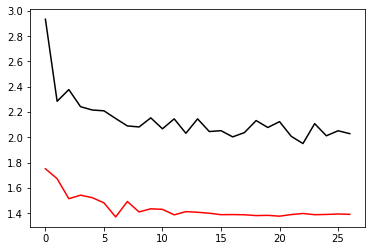

'\n        for i in range(0, 10):\n            img = classical_augm_net(image / 255, training=True)\n            _ = plt.imshow(img)\n            plt.show()\n'

In [8]:
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.metrics import confusion_matrix
import cv2
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
import matplotlib.pyplot as plt
import pandas as pd
#from tensorflow.metrics import F1Score
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.applications import efficientnet_v2, efficientnet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions, EfficientNetV2S
# from tensorflow.math import confusion_matrix
import os
import keras


def classical_augmentation(INPUT_FOLDER_ADDRESS, OUTPUT_FOLDER_ADDRESS):
    classical_augm_net = Sequential([RandomFlip("horizontal"),
                                     RandomRotation(factor=(-0.05, 0.05)),
                                     RandomTranslation(height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15),
                                                       fill_mode='constant'), ])

    # take ls of files in the input folder
    ls = os.listdir(INPUT_FOLDER_ADDRESS)
    #print(ls)
    # loop across the ls of files
    for file in ls:
        #print(str(file)[-4:])
        if str(file)[-4:] == '.png':
            print(file[:-4])


            #   import image w cv2
            image = cv2.imread(str(INPUT_FOLDER_ADDRESS+'/'+str(file)))

            for ix in range(0, 10):
                img = classical_augm_net(image, training=True)
                img = img.numpy()
                print(type(img))
                print(img.shape)
                # plt.savefig(img, OUTPUT_FOLDER_ADDRESS + '/' + pic_name[:-4] + '_' + str(ix))
                cv2.imwrite(OUTPUT_FOLDER_ADDRESS + '/' + str(file)[:-4] + '_' + str(ix)+'.png', img)



def calculate_labels_for_classical_augm_data(ADDRESS_OLD_DATAFRAME, ADDRESS_NEW_DATAFRAME):
    # take ls of files in the input folder
    data = []
    df = pd.read_csv(ADDRESS_OLD_DATAFRAME, header=0, index_col=0)
    df = df[['ix', 'mask_condition']]
    ls_ix = df['ix'].values.astype('str')

    #print(ls_ix)

    for name in ls_ix:
        for i in range(0,10):
            print([name+'_'+str(i), df[df['ix'].astype('str')==name]['mask_condition'].values[0]])
            data.append([name+'_'+str(i), df[df['ix'].astype('str')==name]['mask_condition'].values[0]])

    #print(data)
    df2 = pd.DataFrame(data, columns=['ix', 'mask_condition'])
    df2['mask_condition'] = df2['mask_condition'].apply(lambda row : 0 if str(row)=='with_mask' else (1 if str(row)=='mask_weared_incorrect' else 2))
    print(df2)
    df2.to_csv(path_or_buf=ADDRESS_NEW_DATAFRAME)

    #ls = os.listdir(INPUT_FOLDER_ADDRESS)


def calculate_labels(ADDRESS_OLD_DATAFRAME, ADDRESS_NEW_DATAFRAME):
    # take ls of files in the input folder
    data = []
    df = pd.read_csv(ADDRESS_OLD_DATAFRAME, header=0, index_col=0)
    df = df[['ix', 'mask_condition']]
    df['mask_condition'] = df['mask_condition'].apply(lambda row : 0 if str(row)=='with_mask' else (1 if str(row)=='mask_weared_incorrect' else 2))
    print(df)
    df.to_csv(path_or_buf=ADDRESS_NEW_DATAFRAME)

    #ls = os.listdir(INPUT_FOLDER_ADDRESS)


def replace_incorrect_names(x):
    if str(x[-3:]) == 'png':

        return x
    else:
        #print(x[-3:])
        return '0_0_0.png'


def replace_incorrect_names_val(x):
    if str(x[-3:]) == 'png':
        return x
    else:
        pass
        #print(x[-3:])
        #return '0_0_0.png'


def repl_incorrect_names_from_list(ls):
    out_ls=[]
    for x in ls:
        if str(x[-3:]) == 'png':
            out_ls= out_ls.append(str(x))
        else:
            pass
    print(out_ls)
    return out_ls


def weighted_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in np.product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])

    return K.categorical_crossentropy(y_pred, y_true) * final_mask


def generate_weight_matrix():
    w = np.zeros((3, 3))
    w[0, 0] = 25.5/100
    w[0, 1] = 25.5/100
    w[0, 2] = 25.5/100
    w[1, 0] = 2/100
    w[1, 1] = 2/100
    w[1, 2] = 2/100
    w[2, 0] = 6/100
    w[2, 1] = 6/100
    w[2, 2] = 6/100
    return w

def generate_training_batch(batch_size, PATH_IMAGES = '/Volumes/seagate_expans/classical_augm_images/images',
                            PATH_LABELS = '/Volumes/seagate_expans/classical_augm_images/annotations/annotations.csv'
                             ):
    ls = []
    ls_files = os.listdir(PATH_IMAGES)

    sample_images = random.sample(ls_files, batch_size)
    sample_images = list(map(replace_incorrect_names, sample_images))
    print(sample_images)
    # print(sample_images)
    for img_name in sample_images:
        #print(img_name[:-4])
        #print(PATH_IMAGES + '/'+str(img_name)+'.png')
        img=cv2.imread(PATH_IMAGES + '/'+str(img_name))
        ls.append(img)
        #print(ls)

    df = pd.read_csv(PATH_LABELS, header=0, index_col=0)


    sample_images = [element[:-4] for element in sample_images]

    y = df[df.ix.isin(sample_images)]['mask_condition'].to_numpy()

    #print(y)
    print(np.array(ls, dtype='float64').shape)
    print(y.shape)
    print(y)
    X = np.array(ls, dtype='float64').reshape((batch_size, 80, 80, 3))
    return X, y

    #print(sample_images)
        #ls.append

def get_img_names_list(PATH_IMAGES):

    ls_files = os.listdir(PATH_IMAGES)
    for element in ls_files:
        if element.startswith('.'):
            ls_files.remove(element)
        else:
            pass
    return ls_files


def generate_training_data(batch_size, PATH_IMAGES = '/Volumes/seagate_expans/classical_augm_images/images',
                            PATH_LABELS = '/Volumes/seagate_expans/classical_augm_images/annotations/annotations.csv'
                             ):
    ls = []



    #ls_files = os.listdir(PATH_IMAGES)

    ls_files = get_img_names_list(PATH_IMAGES)
    print(len(ls_files))
    sample_images = random.sample(ls_files, batch_size)


    #if '.DS_store' in sample_images:
    #    sample_images=sample_images.remove('.DS_store')

    sample_images = list(map(replace_incorrect_names, sample_images))
#    sample_images = repl_incorrect_names_from_list(sample_images)
    # print(sample_images)
    # print(sample_images)
    for img_name in sample_images:
        #print(img_name[:-4])
        #print(PATH_IMAGES + '/'+str(img_name)+'.png')
        img=cv2.imread(PATH_IMAGES + '/'+str(img_name))
        ls.append(img)
        #print(ls)

    df = pd.read_csv(PATH_LABELS, header=0, index_col=0)


    sample_images = [element[:-4] for element in sample_images]

    y = df[df.ix.isin(sample_images)]['mask_condition'].to_numpy()

    #print(y)
    #print(len(sample_images))
    #annot=pd.read_csv('/Volumes/seagate_expans/classical_augm_images/annotations/annotations.csv', header=0)['ix'].to_numpy().tolist()
    #print(sample_images)
    #quit()
    #print('printing annot:')
    #print(annot)
    #flat_list = [str(item) for sublist in annot for item in sublist]

    #print(set(sample_images).difference(set(flat_list)))
    #quit()
    #print(df[~df.ix.isin(sample_images)].to_numpy())
    #quit()
    #print(np.array(ls, dtype='float64').shape)
    print(y.shape)
    print(y)
    X = np.array(ls, dtype='float64').reshape((batch_size, 80, 80, 3))
    return X, y

    #print(sample_images)
        #ls.append



def generate_validation_batch(batch_size, PATH_IMAGES = '/Volumes/seagate_expans/val_classical_augm_images/images',
                            PATH_LABELS = '/Volumes/seagate_expans/processed_images/annotations.csv'
                             ):
    ls = []
    ls_files = os.listdir(PATH_IMAGES)

    sample_images = random.sample(ls_files, batch_size)
    sample_images = list(map(replace_incorrect_names_val, sample_images))
    #print(sample_images)
    # print(sample_images)
    for img_name in sample_images:
        #print(img_name[:-4])
        #print(PATH_IMAGES + '/'+str(img_name)+'.png')
        img=cv2.imread(PATH_IMAGES + '/'+str(img_name))
        ls.append(img)
        #print(ls)

    df = pd.read_csv(PATH_LABELS, header=0, index_col=0)


    sample_images = [element[:-4] for element in sample_images]

    y = df[df.ix.isin(sample_images)]['mask_condition'].apply(lambda x: 0 if str(x)=='with_mask' else (1 if str(x)=='mask_weared_incorrect' else 2)).to_numpy()

    #print(y)
    #print(np.array(ls, dtype='float64').shape)
    #print(y.shape)
    # print(y)
    X = np.array(ls, dtype='float64').reshape((batch_size, 80, 80, 3))
    return X, y

# strategy 1 = train the network with no pretrained parameters,
# train the network only with real + classical augmented data
def train_network_strategy_1(n_epochs=120, n_batch_update = 128, batch_size=64, val_batch_size=407, save_freq_param=50, PATH_VAL_IMGS = '/Volumes/seagate_expans/val_classical_augm_images/images'):
    # model instantiation
    base_model = EfficientNetV2S(include_top=True,
                            weights=None,
                            input_tensor=None,
                            input_shape=(80, 80, 3),
                            pooling=None,
                            classes=3,
                            classifier_activation="softmax",
                            include_preprocessing=True)

    #model = Sequential()
    #for layer in base_model.layers[:-1]:
    #    model.add(layer)
    #model.add(Dense(1, activation='softmax'))
    model2 = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    dense = Dense(1000, activation='relu')(model2.output)
    output = Dense(3, activation='softmax')(dense)

    tot_model = Model(inputs=base_model.input, outputs=output)

    # devo togliere l'ultimo layer e aggiungere un Dense(1)

    tot_model.summary()

    # define optimizer &  scheduler

    lr_schedule = ExponentialDecay(initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9)
    opt = Adam(learning_rate=lr_schedule)

    # define a loss function
    loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    w_m = generate_weight_matrix()
    #loss_weighted_classes = weighted_categorical_crossentropy(weights=w_m)

    # training and validation metric
    training_metric = keras.metrics.AUC()
    val_metric = keras.metrics.AUC()

    # model compilation
    #tot_model.compile(loss=loss_function, optimizer=opt, metrics=['AUC'])


    for n in range(n_epochs):
        for b in range(n_batch_update):
            print('Epoch: {}, step: {}'.format(n, b))

            # generate training batches

            X_batch_train, y_batch_train = generate_training_batch(batch_size)
            X_batch_train = preprocess_input(X_batch_train)


            # generate validation batches
            X_batch_val, y_batch_val = generate_validation_batch(val_batch_size)
            X_batch_val = preprocess_input(X_batch_val)



            # generate one hot encoded y variables
            y_train_one_hot = np.array(pd.Series(y_batch_train).apply(
                lambda x: [1, 0, 0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1])).values.tolist()).reshape(
                (batch_size, 3))
            y_val_one_hot = np.array(pd.Series(y_batch_val).apply(
                lambda x: [1, 0, 0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1])).values.tolist()).reshape(
                (val_batch_size, 3))

            # batch updates
            # tot_model.train_on_batch(X_batch_train, y_batch_train)
            with tf.GradientTape() as tape:

                logits = tot_model(X_batch_train, training=True)
                #print(y_batch_train)
                #print(logits)
                lgts = logits.numpy().flatten().reshape((batch_size, 3))
                loss_value = loss_function(y_batch_train.reshape((batch_size,1)),logits )
                #loss_value = weighted_categorical_crossentropy(y_batch_train.reshape((batch_size,1)),logits, w_m )
                print(loss_function(y_batch_train.reshape((batch_size,1)),lgts ))
                #quit()
            grads = tape.gradient(loss_value, tot_model.trainable_weights)
            opt.apply_gradients(zip(grads, tot_model.trainable_weights))

            # update training metric
            training_metric.update_state(y_train_one_hot, logits)



            #print(training_metric)

            # Log every 200 batches.
            if b % 10 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.5f"
                    % (b, float(loss_value))
                )
                print("Seen so far: %d samples" % ((b + 1) * batch_size))

        # Display metrics at the end of each epoch.
        train_value = training_metric.result()
        print("Training AUC over epoch: %.4f" % (float(train_value),))

        # Reset training metrics at the end of each epoch
        training_metric.reset_states()
        # if n_epochs % save_param == 0:


        val_logits = tot_model(X_batch_val, training=False)
        # Update val metrics
        val_metric.update_state(y_val_one_hot, val_logits)
        val_metric_value = val_metric.result()
        val_metric.reset_states()
        print("Validation AUC: %.4f" % (float(val_metric_value),))
        #print("Time taken: %.2fs" % (time.time() - start_time))

        # tot model saved weights
        if n % save_freq_param == 0:
            tot_model.save_weights('models/effectivenet_epoch_'+str(n))


def freq_class(int_class, PATH_TO_ANNOTATIONS = 'processed_images/annotations/annotations.csv'):
    df = pd.read_csv(PATH_TO_ANNOTATIONS, header=0, index_col=0)
    class_count = df[df['mask_condition'].astype('int32')==int_class].count().values[0]
    #print(class_count)
    tot_count = len(df.index)
    #print(tot_count)
    return class_count/tot_count



def train_evaluate_network_strategy_1(training_set_size = 2390, n_epochs=350,
                                      n_batch_update = 32,
                                      batch_size=64,
                                      val_ratio=0.2,
                                      save_freq_param=50, class_weights={0:1,1:7, 2:2.5},
                                      PATH_TRAIN_IMGS = '/Volumes/seagate_expans/processed_images/images',
                                      PATH_TEST_IMGS = '/Volumes/seagate_expans/test_images',
                                      PATH_ANNOTATIONS = '/Volumes/seagate_expans/processed_images/annotations/annotations.csv',
                                      PATH_TEST_ANNOTATIONS = '/Volumes/seagate_expans/val_classical_augm_images/images'):
    # model instantiation
    base_model = EfficientNetV2S(include_top=False,
                            weights='imagenet',
                            input_tensor=None,
                            input_shape=(80, 80, 3),
                            pooling=None,
                            #classes=3,
                            #classifier_activation="softmax",
                            include_preprocessing=True)

    #model = Sequential()
    #for layer in base_model.layers[:-1]:
    #    model.add(layer)
    #model.add(Dense(1, activation='softmax'))
    base_model.trainable=False

    #model2 = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    #dense = Dense(512, activation='relu')(model2.output)
    #dropout = Dropout(0.2)(dense),
    #output = Dense(3, activation='sigmoid')(dropout)

    tot_model2 = keras.Sequential([
    # To a base pretrained on ImageNet to extract features from images...
    base_model,
    # ... attach a new head to act as a classifier.
    GlobalAveragePooling2D(),
    #Dense(10,activation = "relu"),
    #Dropout(0.4),
    #Dense(10,activation = "relu"),
    #Dropout(0.4),
    Dense(3, activation='softmax')
    ])


    pretrained_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=(80, 80, 3)
    )
    pretrained_model.trainable = False
    
    tot_model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1000,activation = "relu"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(3, activation='softmax')
    ])




    #tot_model = Model(inputs=base_model.input, outputs=output)
    #tot_model=base_model
    tot_model.summary()

    # define optimizer &  scheduler
    lr_schedule = ExponentialDecay(initial_learning_rate=0.000005,#0.00001
    decay_steps=5,
    decay_rate=0.975)
    opt = Adam(learning_rate=lr_schedule)
    opt2 = RMSprop(learning_rate=lr_schedule, momentum=0.95)
    # define a loss function
    loss_function = keras.losses.CategoricalCrossentropy(from_logits=False)

    # callback for early stoppage
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


    # model compilation
    tot_model.compile(loss=loss_function, optimizer=opt, metrics=[AUC()])

    # load training validation data
    X, y = generate_training_data(training_set_size, PATH_TRAIN_IMGS, PATH_ANNOTATIONS)
    X = preprocess_input(X)

    print(X.shape)
    print(y.shape)
    y_train_one_hot = np.array(pd.Series(y).apply(
        lambda x: [1, 0, 0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1])).values.tolist()).reshape(
        (training_set_size, 3))

    training_metrics = tot_model.fit(x = X, y = y_train_one_hot,
                  epochs=n_epochs,
                  batch_size=batch_size,
                  steps_per_epoch=n_batch_update,
                  validation_split=val_ratio,
                  #class_weight=class_weights,
                  #class_weight=None,
                  shuffle=True, # shuffles after selecting validation data
                  callbacks=[callback],
                  workers=-1,
                  use_multiprocessing=True,
                  verbose=2)

    # loading test data
    X_test, y_test = generate_training_data(400, PATH_TEST_IMGS, PATH_TEST_ANNOTATIONS)
    X_test = preprocess_input(X_test)

    y_test_one_hot = np.array(pd.Series(y_test).apply(
        lambda x: [1, 0, 0] if x == 0 else ([0, 1, 0] if x == 1 else [0, 0, 1])).values.tolist()).reshape(
        (400, 3))

    test_metrics = tot_model.evaluate(x=X_test, y=y_test_one_hot, steps=3)

    # calculate test metrics
    y_preds = tot_model.predict(X_test)
    print(y_preds.argmax(axis=1))
    cm = confusion_matrix( y_test, y_preds.argmax(axis=1))
    print(test_metrics)
    print(cm)


    return training_metrics, test_metrics, tot_model


        # tot model saved weights
        #if n % save_freq_param == 0:
        #    tot_model.save_weights('models/effectivenet_epoch_'+str(n))

# return ls of f1 scores
def calculate_element_wise_f1_score(ls_prec, ls_recall):
    prec=np.array(ls_prec)
    rec=np.array(ls_recall)
    return 2*prec*rec/(prec+rec)


if __name__ =='__main__':

    ANNOTATIONS_ADDRESS = '/Volumes/seagate_expans/input_data/annotations'
    INPUT_IMAGES_ADDRESS = '/Volumes/seagate_expans/input_data/images'
    OUTPUT_IMAGES_ADDRESS = '/Volumes/seagate_expans/input_data/out_images'

    INPUT_FOLDER_ADDRESS = '/Volumes/seagate_expans/processed_images'
    OUTPUT_FOLDER_ADDRESS =  '/Volumes/seagate_expans/classical_augm_images/images'

    # classical_augmentation(INPUT_FOLDER_ADDRESS, OUTPUT_FOLDER_ADDRESS)
    # calculate_labels_for_classical_augm_data('/Volumes/seagate_expans/processed_images/annotations.csv' )
    # calculate_labels('/Volumes/seagate_expans/processed_images/annotations/annotations.csv', '/Volumes/seagate_expans/processed_images/annotations.csv')

    # VALIDATION DATA
    VALIDATION_DATA_PATH = '/Volumes/seagate_expans/val_classical_augm_images/images'

    # TEST DATA
    TEST_DATA_PATH = '/Volumes/seagate_expans/test_images'


    DATA_FIRST_PART_TRAINING = 'address'
    DATA_SECOND_PART_TRAINING = 'address'



    freq0 = freq_class(0)
    freq1 = freq_class(1)
    freq2 = freq_class(2)


    #X, y = generate_training_batch(batch_size=BATCH_SIZE)
    #X = preprocess_input(X)

    training_metrics, test_metrics, tot_model = train_evaluate_network_strategy_1(training_set_size = 19000, 
                                                                                  n_epochs=200,
                                      n_batch_update = 32,
                                      batch_size=256, 
                                     PATH_TRAIN_IMGS = 'classical_augm_images/images',
                                      PATH_TEST_IMGS = 'test_images',
                                      PATH_ANNOTATIONS = 'classical_augm_images/annotations/annotations.csv',
                                      PATH_TEST_ANNOTATIONS = 'processed_images/annotations/annotations.csv')
    print(training_metrics.history)
    print('Test metrics: {}'.format(test_metrics))

    #[a * b for a, b in zip(lista, listb)]

    '''
    f1_training = calculate_element_wise_f1_score(training_metrics.history['precision'],
                                                  training_metrics.history['recall'])
    f1_val = calculate_element_wise_f1_score(training_metrics.history['val_precision'],
                                             training_metrics.history['val_recall'])
    
    '''



    #fig, axs = plt.subplots(1)
    #fig.suptitle('Train vs Validation metrics')

    plt.plot(training_metrics.history['loss'], color='k')
    plt.plot(training_metrics.history['val_loss'], color='r')
    #axs[0].plot(training_metrics.history['val_loss'], color='r')
    #axs[0].set(ylabel='Trainloss')
    plt.show()

    
    #axs[1].set(ylabel = 'Val loss')
    #axs[1].plot(training_metrics.history['val_precision'], color='r')
    #axs[1].set(ylabel='Precision')




    '''
    axs[2].plot(training_metrics.history['recall'], color='k')
    axs[2].plot(training_metrics.history['val_recall'], color='r')
    axs[2].set(ylabel='Recall')
    
    
    axs[3].plot(training_metrics.history['auc'], color='k')
    axs[3].plot(training_metrics.history['val_auc'], color='r')
    axs[3].set(ylabel='AUC')
    axs[3].set(ylabel='F1 score', xlabel='Epoch')

    '''

    





    '''
    model = EfficientNetV2S( include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True)
    '''


    '''
    classical_augm_net = Sequential([RandomFlip("horizontal"),
                                     RandomRotation(factor = (-0.05, 0.05)),
                                     RandomTranslation(height_factor=(-0.15, 0.15), width_factor = (-0.15, 0.15), fill_mode = 'constant' ),])

    image = cv2.imread('0_1.png')

    '''





'''
        for i in range(0, 10):
            img = classical_augm_net(image / 255, training=True)
            _ = plt.imshow(img)
            plt.show()
'''

